In [1]:
import numpy as np
import scipy as sp
import scipy.linalg

from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import Operator

from utils_decompose import ucry_decomposition_optimize, cos_sin_decomposition, demultiplexor, global_phase_gate
from utils_block_encode import is_unitary, block_encode_matrix, transfer_matrix, abc_decomposition
from utils_block_encode import control_ucry, control_ucrz
from utils import matrix_distance,universal_ud ,universal_cu,universal_cu_2, universal_be

In [2]:
rng = np.random.RandomState()

N = 4
N_= N
M = rng.rand(N,N)*20-10 + (rng.rand(N,N)*20-10)*1j

if np.log2(N).is_integer() == False:
    M_ = M
    N = 2**int(np.ceil(np.log2(N)))
    M = rng.rand(N,N)*20-10 + (rng.rand(N,N)*20-10)*1j
    M[:N_,:N_] = M_

Q = int(np.log2(N))+1
R = np.linalg.norm(M)

if R > 1: 
    print("Random matirx:\n",np.round(M,3)[:N_,:N_])
    print("-> divisor:",R)
    M = M/R

print("Matrix with norm < 1:\n",np.round(M,3))

Random matirx:
 [[ 7.672+8.553j  5.585-6.019j  7.572-7.552j  8.517-6.419j]
 [-1.768+9.3j    4.074+8.238j  8.193+0.845j -8.698+5.894j]
 [-5.024+8.529j -7.048-5.163j  5.701+7.701j -8.242-9.704j]
 [-2.314+1.803j -4.375+7.772j -4.621-5.57j  -3.764-1.834j]]
-> divisor: 36.961428230346776
Matrix with norm < 1:
 [[ 0.208+0.231j  0.151-0.163j  0.205-0.204j  0.23 -0.174j]
 [-0.048+0.252j  0.11 +0.223j  0.222+0.023j -0.235+0.159j]
 [-0.136+0.231j -0.191-0.14j   0.154+0.208j -0.223-0.263j]
 [-0.063+0.049j -0.118+0.21j  -0.125-0.151j -0.102-0.05j ]]


In [3]:
U, D, V = np.linalg.svd(M, full_matrices=True)
M_enlarge,U_enlarge,D_enlarge,V_enlarge = block_encode_matrix(M,U,D,V,N)

# print("Encoded matrix:")
# print("-> untary:", is_unitary(M_enlarge))

# print("Decomposed matrix:")
# print("-> untary:", is_unitary(U_enlarge@D_enlarge@V_enlarge))

##### Encode enlarged matrix using Unitary Decomposition

Successfully encode enlarged matrix using Unitary Decomposition: True
Fidelity (matrix size: 4): 1.1276616889493307e-14
CNOT counts: 23


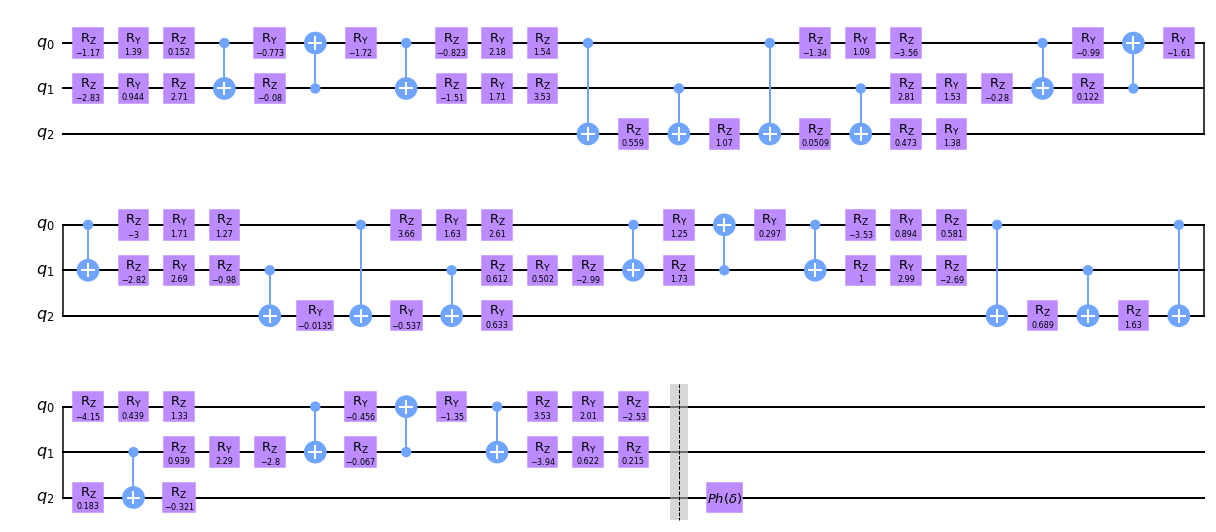

In [4]:
qc = QuantumCircuit(Q)
phase = 0

phase = universal_ud(qc,U_enlarge@D_enlarge@V_enlarge,range(Q),phase)
qc.barrier()
global_phase_gate(qc,phase,2)

# print("Matrix:\n",np.round(U_enlarge@D_enlarge@V_enlarge,3)[:N_,:N_])
# print("-> untary:", is_unitary(U_enlarge@D_enlarge@V_enlarge))

# print("Circuit matrix:\n",np.round(np.matrix(Operator(qc)),3)[:N_,:N_])
# print("-> untary:", is_unitary(Operator(qc)))

print("Successfully encode enlarged matrix using Unitary Decomposition:",np.allclose(M[:N_,:N_],np.matrix(Operator(qc))[:N_,:N_]))
print("Fidelity (matrix size: {}):".format(N_),matrix_distance(M,np.matrix(Operator(qc))[:N_,:N_]))
print("CNOT counts:", qc.count_ops()['cx'])
qc.draw(output="mpl")

##### Encode matrix using Block Encoding

Matrix:
 [[ 0.208+0.231j  0.151-0.163j  0.205-0.204j  0.23 -0.174j]
 [-0.048+0.252j  0.11 +0.223j  0.222+0.023j -0.235+0.159j]
 [-0.136+0.231j -0.191-0.14j   0.154+0.208j -0.223-0.263j]
 [-0.063+0.049j -0.118+0.21j  -0.125-0.151j -0.102-0.05j ]]
-> untary: False
Circuit matrix (upper left block):
 [[ 0.208+0.231j  0.151-0.163j  0.205-0.204j  0.23 -0.174j]
 [-0.048+0.252j  0.11 +0.223j  0.222+0.023j -0.235+0.159j]
 [-0.136+0.231j -0.191-0.14j   0.154+0.208j -0.223-0.263j]
 [-0.063+0.049j -0.118+0.21j  -0.125-0.151j -0.102-0.05j ]]
-> untary: True
Successfully encode matrix using Block Encoding: True
Fidelity (matrix size: 4): 1.0705310133152505e-15
CNOT counts: 9


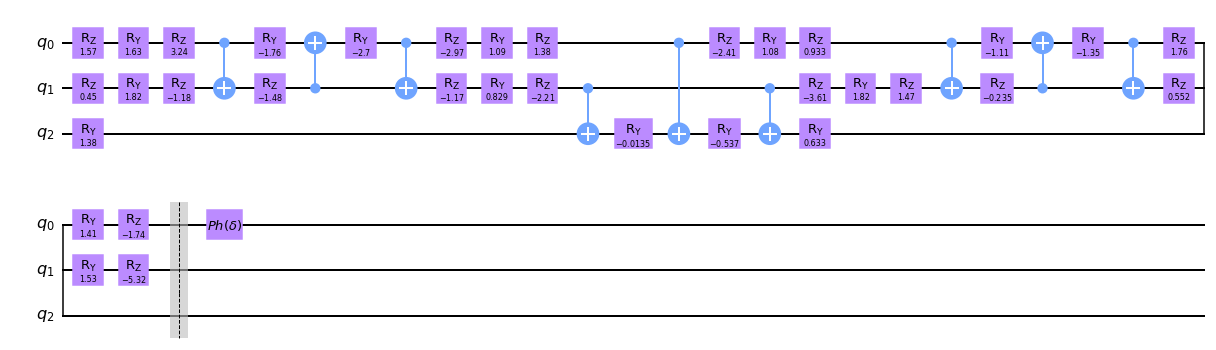

In [5]:
qc = QuantumCircuit(Q)
phase = 0

# phase = universal_ud(qc,V,range(Q-1),phase)
# qc.barrier()

# ucry_decomposition_optimize(qc,Q,np.real(D_enlarge@transfer_matrix(N)),range(Q))

# qc.barrier()
# phase = universal_ud(qc,U,range(Q-1),phase)

phase = universal_be(qc,M,range(Q),phase)

qc.barrier()
global_phase_gate(qc,phase,0)

print("Matrix:\n",np.round(M,3)[:N_,:N_])
print("-> untary:", is_unitary(M))

# print("Circuit matrix (upper left block):\n",np.round(np.matrix(Operator(qc)),3)[:N_*2,:N_*2])
print("Circuit matrix (upper left block):\n",np.round(np.matrix(Operator(qc)),3)[:N_,:N_])
print("-> untary:", is_unitary(Operator(qc)))

print("Successfully encode matrix using Block Encoding:",np.allclose(M[:N_,:N_],np.matrix(Operator(qc))[:N_,:N_]))
# print(np.round(M,3)[:N_,:N_] == np.round(np.matrix(Operator(qc)),3)[:N_,:N_])
print("Fidelity (matrix size: {}):".format(N_),matrix_distance(M[:N_,:N_],np.matrix(Operator(qc))[:N_,:N_]))
print("CNOT counts:", qc.count_ops()['cx'])
qc.draw(output="mpl")